# Single Experiment Data Cut

## Library Import

In [1]:
from nptdms import TdmsFile
import csv
import matplotlib.pyplot as plt
import pandas as pd
import math
import json
import numpy as np
from scipy.stats import linregress

## Experiment TDMS and EMS data

- future ideas: create variable with the experiment number and {i} in TDMS directory and looks for the exp_loc according to a for loop 

In [2]:
directory = r'C:\Users\sted9\Mica\PIL313.tdms'
exp_loc = 0 # Row line on EMS

In [3]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32,
                              np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [4]:
# Machine Parameters
vtoinch = 0.17153
vtoIL_coarse = 1280 #high stresses or very cold conditions
vtoIL_fine = 202
sample_r = 0.55
R = 0.0083145 #KJ/mol
Q_DC = 181 # Dislocation Creep Activation Energy (KJ/mol)

# EMS Data
col_EMS = ['Experiment Number', 'Date', 'Target Temperature', 'Grain Size', 
    'Target Strain Rate', 'Initial Length', 'Final Length', 'Target Pressure', 'Internal Axial Load Read', 'Storage', 'Exp Start', 'Exp Finish']
exp_EMS = pd.read_csv (r'C:\Users\sted9\Mica\AEEM.csv', names = col_EMS, skiprows=1)

i = exp_EMS['Experiment Number'][exp_loc]
L0 = exp_EMS['Initial Length'][exp_loc] # Original Sample Lenght
SR_exp = exp_EMS['Target Strain Rate'][exp_loc] # Target Strain Rate
GS_exp = exp_EMS['Grain Size'][exp_loc] # Grain Size (Coarse, Standard or Fine)
temp_target = exp_EMS['Target Temperature'][exp_loc]
pressure_target = exp_EMS['Target Pressure'][exp_loc]
start = exp_EMS['Exp Start'][exp_loc]
finish = exp_EMS['Exp Finish'][exp_loc]

# TDMS File Information
tdms_file = TdmsFile.open(directory)
temp = tdms_file['Temperature']['Piston 13mm'][:]
disp = tdms_file['Displacement']['Left Axial'][:]
IL = tdms_file['Load and Pressure']['Semi Internal'][:]
time = tdms_file['Time']['Time'][:]

## Raw Stress & Strain

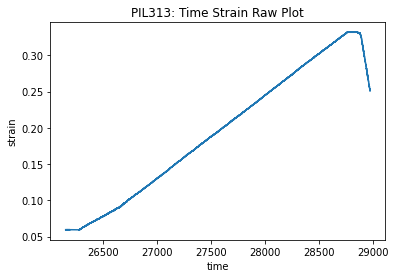

In [5]:
Lf_raw = L0 - disp * vtoinch
stress_raw = -(IL * vtoIL_fine * Lf_raw / (sample_r**2 * math.pi * L0))
strain_raw = np.log(L0 / Lf_raw)

plt.plot(time, strain_raw)
plt.xlabel('time')
plt.ylabel('strain')
plt.title(f'PIL{i}: Time Strain Raw Plot')
plt.show()

## Cutting the Data

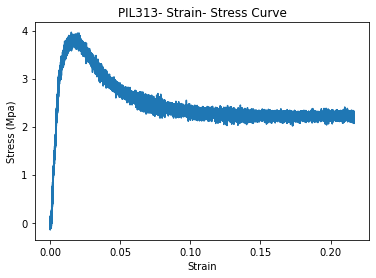

In [7]:
#start = [n for n,i in enumerate(time) if i> 106950][0]
#finish = [n for n,i in enumerate(time) if i> 108700][0]

Lf_raw = L0 - (disp[start:finish] - disp[start]) * vtoinch
stress = -((IL[start:finish] * vtoIL_fine * Lf_raw / (sample_r**2 * math.pi * L0))-(IL[start] * vtoIL_fine * Lf_raw / (sample_r**2 * math.pi * L0)))
strain = np.log(L0 / Lf_raw)

plt.plot(strain,stress)
plt.xlabel('Strain')
plt.ylabel('Stress (Mpa)')
plt.title(f'PIL{i}- Strain- Stress Curve')
plt.show()

## Peak and Flow Strain & Strain

In [8]:
stress_peak_loc = np.argmax(stress)
stress_peak = stress[stress_peak_loc]
temp_peak = temp[stress_peak_loc]
slopeSR, interceptSR, r_valueSR, p_valueSR, std_errSR = linregress (time[start:finish],strain) # lin regress over all data
SR_peak = slopeSR *  np.exp((- Q_DC / R) * ((1/temp_target)-(1/temp_peak))) # with correction
stress_flow = np.mean(stress[-10000:-1])
SR_flow = slopeSR *  np.exp((- Q_DC / R) * ((1/temp_target)-(1/np.mean(temp[(finish-10000):finish]))))


print('Stress Peak =', stress_peak, 'Stress Flow =', stress_flow, 'SR Peak=', SR_peak, 'SR Flow =', SR_flow)

Stress Peak = 3.9641595763288935 Stress Flow = 2.235268858539094 SR Peak= 0.00011676463187652327 SR Flow = 0.00011822457454649816


## Creating JSON

In [9]:
dict = {'Experiment': i, 'L0': L0, 'Strain Rate Exp': SR_exp, 'Grain Size': GS_exp, 'Temperature Exp': temp_target, 'Pressure Exp': pressure_target,
                        'Temperature':temp[start:finish], 
                        'Internal Load':IL[start:finish], 
                        'Displacement':time[start:finish],
                        'Seconds': time[start:finish], 
                        'Stress': stress,
                        'Strain': strain, 
                        'Stress Peak': stress_peak,
                        'Stress Flow': stress_flow,
                        'Strain Rate Peak': SR_peak,
                        'Strain Rate Flow':  SR_flow}

with open(f'PIL{i}.json', 'w') as fp:
    json.dump(dict, fp, cls=NumpyEncoder)